In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from skimage import data, filters
from scipy.interpolate import interpn
import os

In [2]:
igram_date = '20200320_20200401'
work_dir = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'
veloc_fn = f'{work_dir}/mintpy_offsets/velocityRg.h5'
igram_fn = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine.int'
cor_fn = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine.cor'

In [3]:
igram_ds = gdal.Open(igram_fn, gdal.GA_ReadOnly)
igram = igram_ds.GetRasterBand(1).ReadAsArray()

cor_ds = gdal.Open(cor_fn, gdal.GA_ReadOnly)
cor = cor_ds.GetRasterBand(1).ReadAsArray()

In [4]:
ds = xr.open_dataset(veloc_fn)

In [5]:
non_zero_rows = np.any(igram != 0, axis=1)
non_zero_cols = np.any(igram != 0, axis=0)

igram_crop = igram[non_zero_rows][:, non_zero_cols]
cor_crop = cor[non_zero_rows][:, non_zero_cols]

In [6]:
veloc = ds.velocity.values
non_zero_rows = np.any(veloc != 0, axis=1)
non_zero_cols = np.any(veloc != 0, axis=0)

veloc_crop = veloc[non_zero_rows][:, non_zero_cols]

In [7]:
# Find rows and columns with all zeros and remove them in each direction
row_sum = np.sum(igram, axis=1)
col_sum = np.sum(igram, axis=0)
top_padding = 0
bottom_padding = 0
left_padding = 0
right_padding = 0

# Determine top padding
while row_sum[top_padding] == 0:
    top_padding += 1

# Determine bottom padding
while row_sum[-1 - bottom_padding] == 0:
    bottom_padding += 1

# Determine left padding
while col_sum[left_padding] == 0:
    left_padding += 1

# Determine right padding
while col_sum[-1 - right_padding] == 0:
    right_padding += 1

In [8]:
# interpolate to match interferogram dimensions
x_coords = np.linspace(0, veloc_crop.shape[1]-1, veloc_crop.shape[1])
y_coords = np.linspace(0, veloc_crop.shape[0]-1, veloc_crop.shape[0])

# Create a mesh grid for the numpy array's dimensions
x_coords_new, y_coords_new = np.meshgrid(
    np.linspace(x_coords.min(), x_coords.max(), igram_crop.shape[1]),
    np.linspace(y_coords.min(), y_coords.max(), igram_crop.shape[0])
)

# Perform bilinear interpolation using scipy.interpolate.interpn
veloc = interpn((y_coords, x_coords), veloc_crop, (y_coords_new, x_coords_new), method="linear")

In [9]:
# filter to remove some noise
veloc_filtered = filters.butterworth(veloc,
                                     cutoff_frequency_ratio=0.35, #between 0 and 0.5
                                     order=2,
                                     high_pass=False)

In [ ]:
#veloc_low_cor = np.where(cor_crop < 0.9, veloc_filtered, 0)

In [10]:
# convert to phase for simulated 12 day period
veloc_unwrapped = (veloc_filtered-0.6)*(12/365)*(12.5663706/0.05546576)

In [ ]:
# # wrap, convert to complex conjugate, and remove from interferogram
# veloc_wrapped = np.mod(veloc_unwrapped,2*np.pi)
# complex_conjugate_array = np.conjugate(np.exp(1j * veloc_wrapped))
# residual = igram_crop*complex_conjugate_array

In [ ]:
# f, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0), cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0), cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0), cmap='twilight_shifted', interpolation='none')
# ax[1, 1].imshow(np.flip(cor_crop, 0), cmap='Blues', vmin=0.5, vmax=0.501, interpolation='none')
# f.tight_layout()

In [ ]:
# f, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[200:2000, 2000:4500], cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[200:2000, 2000:4500], cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0)[200:2000, 2000:4500], cmap='twilight_shifted', interpolation='none')
# ax[1, 1].imshow(np.flip(cor_crop, 0)[200:2000, 2000:4500], cmap='Blues', vmin=0.5, vmax=0.501, interpolation='none')
# f.tight_layout()

In [ ]:
# f, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
# ax[1, 1].imshow(np.flip(cor_crop, 0)[700:1300, 2700:3300], cmap='Blues', vmin=0.7, vmax=0.701, interpolation='none')
# f.tight_layout()

In [ ]:
# f, ax = plt.subplots(2, 2, figsize=(12, 8))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[900:1100, 2850:3150], cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[900:1100, 2850:3150], cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0)[900:1100, 2850:3150], cmap='twilight_shifted', interpolation='none')
# ax[1, 1].imshow(np.flip(cor_crop, 0)[900:1100, 2850:3150], cmap='Blues', vmin=0, vmax=1, interpolation='none')
# f.tight_layout()

In [11]:
# Add the padding back
# residual_full = np.pad(residual, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
veloc_unwrapped_full = np.pad(veloc_unwrapped, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')

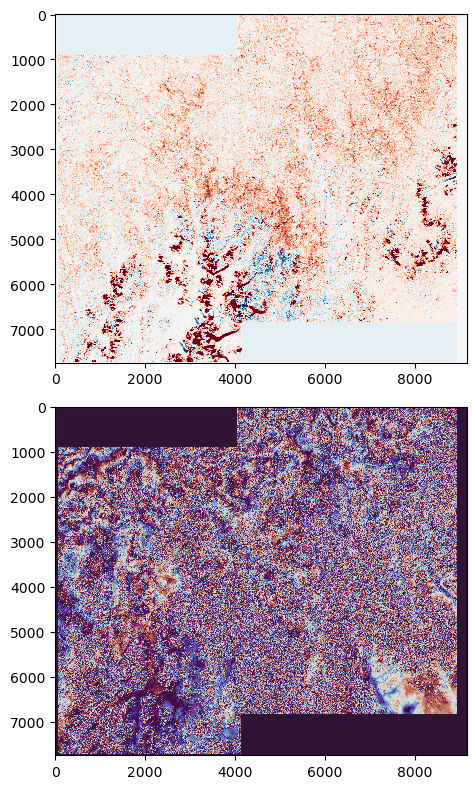

In [12]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].imshow(veloc_unwrapped_full, cmap='RdBu_r', vmin=-50, vmax=50, interpolation='none')
ax[1].imshow(np.angle(igram), cmap='twilight', interpolation='none')
f.tight_layout()

In [13]:
# crop to aoi
veloc_unwrapped_aoi = veloc_unwrapped_full[4746:, 1000:4000]
igram_aoi = igram[4746:, 1000:4000]
cor_aoi = cor[4746:, 1000:4000]

# veloc_unwrapped_aoi = veloc_unwrapped_full[6000:7000, 2500:3500]
# igram_aoi = igram[6000:7000, 2500:3500]
# cor_aoi = cor[6000:7000, 2500:3500]

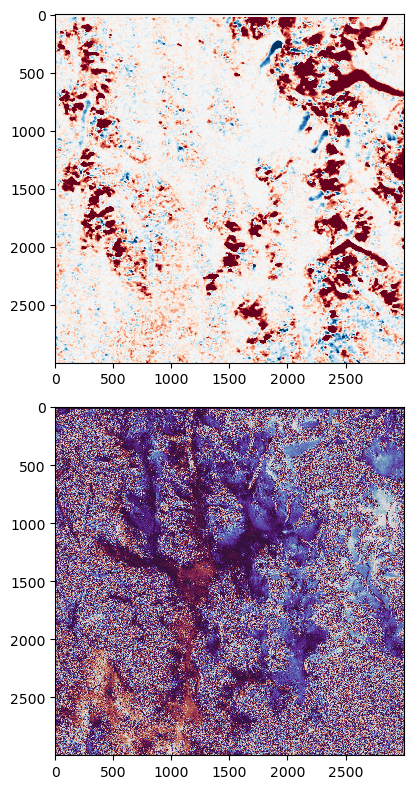

In [14]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].imshow(np.flip(veloc_unwrapped_aoi, 0), cmap='RdBu_r', vmin=-50, vmax=50, interpolation='none')
ax[1].imshow(np.flip(np.angle(igram_aoi), 0), cmap='twilight', interpolation='none')
f.tight_layout()

In [ ]:
veloc_unwrapped_aoi = np.nan_to_num(veloc_unwrapped_aoi, nan=0)
veloc_unwrapped_aoi = veloc_unwrapped_aoi.astype(np.float32)

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/veloc_unwrapped_aoi' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = veloc_unwrapped_aoi.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(veloc_unwrapped_aoi.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(veloc_unwrapped_aoi)
output_ds = None

In [ ]:
igram_aoi = np.nan_to_num(igram_aoi, nan=0)
igram_aoi = igram_aoi.astype(np.complex64)

# # For complex input
# real_array = np.real(igram_aoi).astype(np.float32)
# imaginary_array = np.imag(igram_aoi).astype(np.float32)

# # Stack the real and imaginary parts alternately
# igram_aoi = np.hstack((real_array, imaginary_array))

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine_aoi.int' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = igram_aoi.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(igram_aoi.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(igram_aoi)
output_ds = None

In [ ]:
cor_aoi = np.nan_to_num(cor_aoi, nan=0)
cor_aoi = cor_aoi.astype(np.float32)

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine_aoi.cor' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = cor_aoi.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(cor_aoi.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(cor_aoi)
output_ds = None

In [ ]:
# byte_mask = (cor_aoi > 0.35).astype(np.uint8)

# # save to raster
# output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/cor_mask_0.35' 
# driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
# rows, cols = byte_mask.shape    # Get the number of rows and columns from the NumPy array
# data_type = gdal_array.NumericTypeCodeToGDALTypeCode(byte_mask.dtype)  # Convert NumPy data type to GDAL data type

# # Create the output dataset
# driver = gdal.GetDriverByName(driver_format)
# output_ds = driver.Create(output_file, cols, rows, 1, data_type)

# band = output_ds.GetRasterBand(1)  # Get the single band
# band.WriteArray(byte_mask)
# output_ds = None

In [15]:
os.chdir(f'{work_dir}/work/merged/interferograms/{igram_date}')

In [16]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for snaphu to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [17]:
CONFIG_TXT = f'''# snaphu configuration file
#############################################
# File input and output and runtime options #
#############################################

# Input file name
INFILE	filt_fine_aoi.int

# Input file line length 
LINELENGTH	3000

# Output file name
OUTFILE	fine_filt_aoi_smooth_withest.unw

# Correlation file name
CORRFILE	filt_fine_aoi.cor

# Coarse unwrapped-phase estimate file name (see possible file formats
# below).  The array should have the same dimensions as the input
# wrapped phase array.
ESTIMATEFILE	veloc_unwrapped_aoi

# Input file of signed binary byte (signed char) values.  
# BYTEMASKFILE  cor_mask_0.35

# Text file to which runtime parameters will be logged.  
LOGFILE       snaphu.logfile

# Statistical-cost mode (TOPO, DEFO, SMOOTH, or NOSTATCOSTS)
STATCOSTMODE	SMOOTH

# Algorithm used for initialization of wrapped phase values.  Possible
# values are MST and MCF.  
INITMETHOD	MCF

################
# File formats #
################

# Input file format
INFILEFORMAT		COMPLEX_DATA

# Output file format
OUTFILEFORMAT		FLOAT_DATA

# Correlation file format
CORRFILEFORMAT		FLOAT_DATA

# Unwrapped estimate file format
ESTFILEFORMAT		FLOAT_DATA

################
# Tile control #
################

# Parameters in this section describe how the input files will be 
# tiled.  This is mainly used for tiling, in which different
# patches of the interferogram are unwrapped separately.

# Number of rows and columns of tiles into which the data files are
# to be broken up.
NTILEROW		4
NTILECOL		4

# Overlap, in pixels, between neighboring tiles.
ROWOVRLP		500
COLOVRLP		500

# Maximum number of child processes to start for parallel tile
# unwrapping.
NPROC			16

# Cost threshold to use for determining boundaries of reliable regions
# (long, dimensionless; scaled according to other cost constants).
# Larger cost threshold implies smaller regions---safer, but
# more expensive computationally.  
TILECOSTTHRESH 	800

# Minimum size (long, pixels) of a reliable region in tile mode.  
MINREGIONSIZE		50

# Extra weight applied to secondary arcs on tile edges.
# TILEEDGEWEIGHT	2.5

# Maximum flow magnitude (long) whose cost will be stored in the secondary 
# cost lookup table.  Secondary costs larger than this will be approximated
# by a quadratic function.
# SCNDRYARCFLOWMAX	8

# The program will remove temporary tile files if this is set.
# RMTMPTILE 		FALSE

# This is the name (string) of a file of signed character data types
# which serve as a mask for which tiles will be unwrapped.  The file
# should be a raster array with NTILEROW rows and NTILECOL columns.
# Where the array element is nonzero, the corresponding tile will be
# unwrapped; where the array element is zero, the tile will not be
# unwrapped and no output for that tile will be written.  This option
# is used for reprocessing only certain tiles of a run.
# DOTILEMASKFILE        snaphu.dotilemaskfile.in

# This is the name of the tile directory.  Tiles will be stored
# temporarily in the tile directory.  If in assemble only mode,
# unwrapped tiles  are assumed to reside in this directory.  The
# directory is create if it does not exist.
# TILEDIR		snaphu_tiledir

# If this is set to TRUE, the program will skip the unwrapping step
# and only assemble temporary tile files from a previous invocation
# saved in the directory whose name is given by the TILEDIR keyword.
# The tile size parameters and file names must be the same.
# ASSEMBLEONLY		FALSE

# Repotimize as single tile after using tile mode for intialization if
# this is set to TRUE.  This is equivalent to unwrapping with multiple
# tiles, then using the unwrapped output as the input to a new, single-tile run
# of snaphu with the -u option.  The purpose is for speed.
#SINGLETILEREOPTIMIZE   TRUE

# End of snaphu configuration file'''

config_file = 'snaphu.conf.brief'
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: snaphu.conf.brief


In [ ]:
!snaphu -f snaphu.conf.brief

In [18]:
smooth_withest_file = gdal.Open('fine_filt_aoi_smooth_withest.unw', gdal.GA_ReadOnly)
smooth_withest = smooth_withest_file.GetRasterBand(1).ReadAsArray()
smooth_noest_file = gdal.Open('fine_filt_aoi_smooth_noest.unw', gdal.GA_ReadOnly)
smooth_noest = smooth_noest_file.GetRasterBand(1).ReadAsArray()
# conn_comp_file = gdal.Open('conn_comp_aoi', gdal.GA_ReadOnly)
# conn_comp = conn_comp_file.GetRasterBand(1).ReadAsArray()

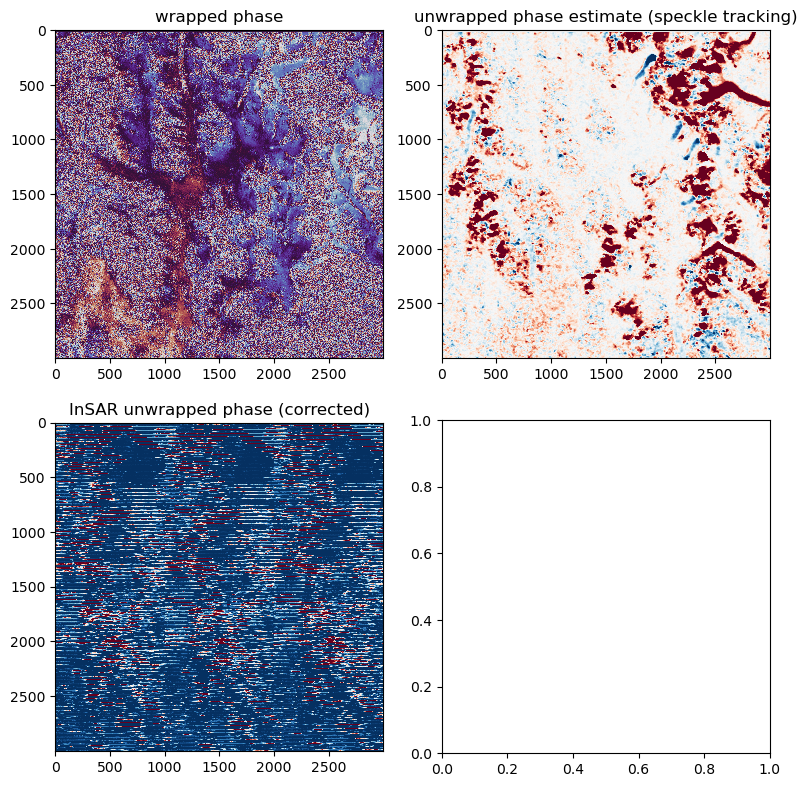

In [19]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.flip(np.angle(igram_aoi), 0), cmap='twilight', interpolation='none')
ax[0, 0].set_title('wrapped phase')
ax[0, 1].imshow(np.flip(veloc_unwrapped_aoi, 0), cmap='RdBu_r', vmin=-50, vmax=50, interpolation='none')
ax[0, 1].set_title('unwrapped phase estimate (speckle tracking)')
ax[1, 0].imshow(np.flip(smooth_withest, 0)-18, cmap='RdBu_r', vmin=-25, vmax=25, interpolation='none')
ax[1, 0].set_title('InSAR unwrapped phase (corrected)')
# ax[1, 1].imshow(np.flip(smooth_noest, 0)-5, cmap='RdBu_r', vmin=-25, vmax=25, interpolation='none')
# ax[1, 1].set_title('InSAR unwrapped phase (no unwrapping correction)')
f.tight_layout()

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.flip(smooth_withest, 0)-18, cmap='RdBu_r', vmin=-30, vmax=30, interpolation='none')
ax.set_title('InSAR unwrapped phase (corrected)')
f.tight_layout()

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.flip(smooth_noest, 0)-6, cmap='RdBu_r', vmin=-30, vmax=30, interpolation='none')
ax.set_title('InSAR unwrapped phase (corrected)')
f.tight_layout()